In [160]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import sklearn
from sklearn.model_selection import train_test_split
import os


from nltk.corpus import wordnet
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to /home/yiwei/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/yiwei/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/yiwei/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [161]:
def data_cleaning(text):
    # 大小写
    text = text.replace('\n', ' ')
    text = text.replace('\r', ' ')
    text = text.replace('\t', ' ')
    text = text.replace("#" , " ")
    text = text.replace("." , "")
    text = text.replace("%", "")



    text = re.sub('https?://[A-Za-z0-9./]+', '', text)
    text = re.sub('http?://[A-Za-z0-9./]+', '', text)
    text = re.sub('www.[A-Za-z0-9./]+', '', text)
    text = re.sub("\d+", "", text)
    text = re.sub("!+", "!", text)

#     text = '!'.join(unique_list(text.split('!')))
    text = re.sub(r'((\b\w+\b.{1,2}\w+\b)+).+\1', r'\1', text, flags = re.I)
    encoded_string = text.encode("ascii", "ignore")
    decode_string = encoded_string.decode()
    return decode_string

In [162]:
!pwd
data_folder_path = './data/'
df = pd.read_csv(data_folder_path + 'train.csv')
test_text = pd.read_csv(data_folder_path + 'test.csv')
test_label = pd.read_csv(data_folder_path + 'test_labels.csv')
test_df = pd.concat([test_text, test_label], axis=1)
classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

/mnt/a/OneDrive/UNSW/COMP9444/9444_toxic_comment_classification


In [163]:
df['comment_text'] = df['comment_text'].apply(data_cleaning)
test_df['comment_text'] = test_df['comment_text'].apply(data_cleaning)

In [169]:
toxic_df = df[(df['toxic'] == 1) | (df['severe_toxic'] == 1) | (df['obscene'] == 1) | (df['threat'] == 1) | (df['insult'] == 1) | (df['identity_hate'] == 1)]
non_toxic_df = df[(df['toxic'] == 0) & (df['severe_toxic'] == 0) & (df['obscene'] == 0) & (df['threat'] == 0) & (df['insult'] == 0) & (df['identity_hate'] == 0)]

replacement_rate =0.3
##  synonym replacement
aug_toxic_df = toxic_df.copy(True)
for i, row in toxic_df.iterrows():
    comment = row['comment_text']
    words = comment.split()
    new_comment = ''
    new_words = []
    for word in words:
        if word in stopwords.words('english'):
            new_words.append(word)
            continue

        random_rate = np.random.uniform(0, 1)

        if random_rate < replacement_rate:
            synonyms = []
            for syn in wordnet.synsets(word):
                for l in syn.lemmas():
                    synonyms.append(l.name())
            if len(synonyms) > 0:
                new_word = synonyms[np.random.randint(0, len(synonyms))]
                new_words.append(new_word)
            else:
                new_words.append(word)


        else:
            new_words.append(word)
    new_comment = ' '.join(new_words)
    new_row = row.copy(True)
    new_row['comment_text'] = new_comment
    aug_toxic_df = aug_toxic_df.append(new_row, ignore_index=True)
    
df = pd.concat([aug_toxic_df, non_toxic_df], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)

/tmp/ipykernel_699/4156914277.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aug_toxic_df = aug_toxic_df.append(new_row, ignore_index=True)
/tmp/ipykernel_699/4156914277.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aug_toxic_df = aug_toxic_df.append(new_row, ignore_index=True)
/tmp/ipykernel_699/4156914277.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aug_toxic_df = aug_toxic_df.append(new_row, ignore_index=True)
/tmp/ipykernel_699/4156914277.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aug_toxic_df = aug_toxic_df.append(new_row, ignore_index=True)
/tmp/ipykernel_699/4156914277.py:36: FutureWarning: The fram

In [165]:
test_df[0:20]
ids_to_drop = []
for i in range(len(test_df)):
    if test_df['toxic'][i] == -1 or test_df['severe_toxic'][i] == -1 or test_df['obscene'][i] == -1 or test_df['threat'][i] == -1 or test_df['insult'][i] == -1 or test_df['identity_hate'][i] == -1:
        ids_to_drop.append(i)

test_df = test_df.drop(ids_to_drop)

test_df.head()

id                                       comment_text  \
5   0001ea8717f6de06  Thank you for understanding I think very highl...   
7   000247e83dcc1211                    :Dear god this site is horrible   
11  0002f87b16116a7f  "::: Somebody will invariably try to add Relig...   
13  0003e1cccfd5a40a  "    It says it even in Binghamton University,...   
14  00059ace3e3e9a53  "    == Before adding a new product to the lis...   

                  id  toxic  severe_toxic  obscene  threat  insult  \
5   0001ea8717f6de06      0             0        0       0       0   
7   000247e83dcc1211      0             0        0       0       0   
11  0002f87b16116a7f      0             0        0       0       0   
13  0003e1cccfd5a40a      0             0        0       0       0   
14  00059ace3e3e9a53      0             0        0       0       0   

    identity_hate  
5               0  
7               0  
11              0  
13              0  
14              0

In [166]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [170]:
from torchtext.vocab import GloVe, vocab

unk_token = "<pad>"
unk_index = 0
#name = "vector_cache"


if os.path.isdir("./.vector_cache"):
    glove_vectors = GloVe(name = 'twitter.27B', cache = './.vector_cache', dim=200)
else:    
    glove_vectors = GloVe('twitter.27B', dim=200)
print(len(glove_vectors.stoi))
glove_vocab = vocab(glove_vectors.stoi)
glove_vocab.insert_token("<pad>",unk_index)
#this is necessary otherwise it will throw runtime error if OOV token is queried
glove_vocab.set_default_index(unk_index)
pretrained_embeddings = glove_vectors.vectors
pretrained_embeddings = torch.cat((torch.zeros(1,pretrained_embeddings.shape[1]),pretrained_embeddings))
print(pretrained_embeddings.shape)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1193513/1193514 [00:10<00:00, 108683.38it/s]


1193514
torch.Size([1193515, 25])


In [204]:
from torch.utils.data import IterableDataset

tokenizer2 = get_tokenizer("basic_english")
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
nlp = English()
# Create a blank Tokenizer with just the English vocab
tokenizer = Tokenizer(nlp.vocab)


class MyDataset(Dataset):

    def __init__(self, dataframe, max_len=100, pad_token='<pad>'):
         self.X = dataframe['comment_text'].values
         self.Y = dataframe[classes].to_numpy()
         self.max_len = max_len
         self.pad_token = pad_token
         # self.unk_token = unk_token

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        t = idx
        tokens = tokenizer(self.X[t])[:self.max_len]
        tokens = [tok.text for tok in tokens]
        # tokens = tokenizer2(tokens)[:self.max_len]

        diff = self.max_len - len(tokens)
        # print('diff',diff)
        if diff > 0:

            tokens = [self.pad_token] * diff + tokens
            # print('tokens',to
        indices = glove_vocab(tokens)
        result = {
            'text': tokens,
            'indices': torch.tensor(indices),
            'labels': torch.tensor(self.Y[t], dtype=torch.float)
        }
        return result


In [205]:
MAX_LEN = 0
for a in range(0 , len(df)):
    f = df["comment_text"][a]
    length = len(f.split())
    if length > MAX_LEN:
        MAX_LEN = length
        
train_dataset = MyDataset(df, MAX_LEN)
test_dataset = MyDataset(test_df, MAX_LEN)

In [206]:
MAX_LEN

265

In [207]:
for data in test_dataset:
    print(data['text'])
    print(data['labels'])
    print(data['indices'])
    break

['<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', 

In [221]:


class TextClassificationModel(nn.Module):

    def __init__(self, pretrained_embeddings, num_class, hidden_size, freeze_embeddings = True):
        super(TextClassificationModel, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze = freeze_embeddings, sparse=False)

        # print(pretrained_embeddings.shape)

        self.lstm = nn.LSTM(pretrained_embeddings.shape[1], hidden_size, num_layers=4, bidirectional=True, dropout=0.5)
        self.fc1 = nn.Linear(hidden_size * 4, hidden_size * 2)
        self.fc2 = nn.Linear(hidden_size * 2, num_class)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.2)
        
        self.LN = nn.LayerNorm(hidden_size * 4)
        self.LN2 = nn.LayerNorm(hidden_size * 2)

    #def attention_net(self, lstm_output):
    #    attn_weight_matrix = self.W_s2(torch.tanh(self.W_s1(lstm_output)))
    #    attn_weight_matrix = attn_weight_matrix.permute(0, 2, 1)
    #    attn_weight_matrix = nn.functional.softmax(attn_weight_matrix, dim=2)
    #    return attn_weight_matrix

    def forward(self, indices):
        #print('input', indices.shape)

        embedded = self.embedding(indices.T)
        # print('embedded', embedded.shape)
        self.lstm.flatten_parameters()
        lstm_out, _ = self.lstm(embedded)

        encoding = torch.cat((lstm_out[0], lstm_out[-1]), dim=1)
        
        out = self.LN(encoding)
        out = self.fc1(out)
        out = self.LN2(out)
        out = self.dropout(out)
        out = self.fc2(out)

        #print('output', out.shape)


        #out = self.sigmoid(out)
        #print('out', out)

        return out

In [222]:
train_dataset

In [223]:
## OK let's try to run this model to see if dimensions are correct!
#glove_model = TextClassificationModel(pretrained_embeddings, len(classes), hidden_size=64, is_batch=False)

#for idx, data in enumerate(train_dataset):
#    print("---------------------------------")
#    print('next example id ', idx)
#    print("---------------------------------")
#    # example_text = data['text']
#    text_input = data['indices']
    # print('tensor_shape: ', text_input.shape)
#    model_output = glove_model(text_input)
    # fwd = glove_model.forward(text_input)
    # print('embedding_bag: ',  fwd.shape)
    # print('output_shape: ', model_output.shape)
#    print('output: ', model_output)

    #if idx == 2:
#    break

In [224]:
from torch.utils.data import DataLoader


BATCH_SIZE = 256

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [225]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

Epoch: 1 Train_Loss: 0.5660106157128876 Train_Accuracy: 0.873466968536377
Epoch: 1 Test_Loss: 0.3730497533082962 Test_Accuracy: 0.9118812084197998 Recall: 0.3870188991585046 Precision: 0.18366612111292963 f1: 0.24911205824897886


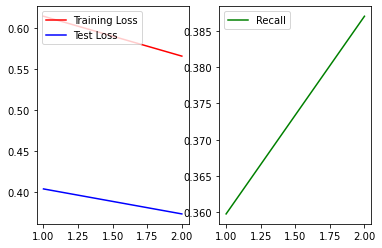

In [ ]:
from IPython.display import clear_output
weights = []
for cls in classes:
    w = len(df) /df[cls].sum()
    # print(cls +' w: ', w)
    weights.append(w)

#loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(weights))
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight = torch.tensor((159571 - 35098) / 35098))
model = TextClassificationModel(pretrained_embeddings, len(classes), hidden_size=128)
gpus = torch.cuda.device_count()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if gpus > 1:
    print("Let's use", gpus, "GPUs!")
    # model = torch.nn.DataParallel(model)    # multi-gpu

loss_fn.to(device)
model.to(device)
optimizer = AdamW(model.parameters(), lr=4e-5, weight_decay=0.0001)

epochs = 100

training_losses = [ None for i in range(epochs)]
test_losses = [ None for i in range(epochs)]
epoch_count = [i for i in range(1, epochs+1)]
recalls = [ None for i in range(epochs)]
precisions = [ None for i in range(epochs)]
for e in range(epochs):
    model.train()
    epoch_loss = 0

    losses = []
    correct_predictions = 0
    for batch_id, batch in enumerate(train_dataloader):

        ids = batch['indices'].to(device)
        #print('ids: ', ids.shape)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(ids)
        probs = torch.sigmoid(outputs)
        preds = torch.where(outputs > 0.5, 1, 0)
        loss = loss_fn(outputs, labels)
        #print('loss: ', loss)

        correct_predictions += torch.sum(preds == labels)

        loss.backward()
        optimizer.step()
        # if batch_id % 100 == 0:
            # print('Epoch: {} Batch: {} Loss: {}'.format(e, batch_id, loss.item()))
            #print(loss.grad_fn)

        losses.append(loss.item())

    epoch_loss = np.mean(losses)

    training_losses[e] = epoch_loss
    train_accuracy = correct_predictions/(len(df)*6)


    if e % 3000 == 0 and e != 0:
        torch.save(model.state_dict(), 'model_epoch_{}.pt'.format(e))

    ## Evaluate on test set
    with torch.no_grad():
        model.eval()
        test_loss = []
        test_correct_predictions = 0
        label_counter = 0
        TP_counter = 0
        FP_counter = 0

        for batch_id, batch in enumerate(test_dataloader):
            ids = batch['indices'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(ids)

            probs = torch.sigmoid(outputs)
            preds = torch.where(outputs > 0.5, 1, 0)
            loss = loss_fn(outputs, labels)

            test_correct_predictions += torch.sum(preds == labels)
            test_loss.append(loss.item())

            labels = labels.to(torch.device("cpu")).numpy()
            preds = preds.to(torch.device("cpu")).numpy()
            for row in range(len(labels)):
                for col in range(len(labels[row])):
                    if labels[row][col] == 1:
                        label_counter += 1
                        if preds[row][col] == 1:
                            TP_counter += 1
                    elif labels[row][col] == 0:
                        if preds[row][col] == 1:
                            FP_counter += 1
        # print(pred_counter, label_counter)
        test_loss = np.mean(test_loss)
        accuracy = test_correct_predictions/(len(test_dataset)*6)
        recall_score = TP_counter / label_counter
        recalls[e] = recall_score
        test_losses[e] = test_loss
        precision_score = TP_counter / (TP_counter + FP_counter)
        precisions[e] = precision_score
        f1_score = 2 * (precision_score * recall_score) / (precision_score + recall_score)

        clear_output()
        print('Epoch: {} Train_Loss: {} Train_Accuracy: {}'.format(e, epoch_loss, train_accuracy))
        print('Epoch: {} Test_Loss: {} Test_Accuracy: {} Recall: {} Precision: {} f1: {}'.format(e, test_loss, accuracy, recall_score, precision_score, f1_score))
        fig, (ax1, ax2) = plt.subplots(1, 2)

        ax1.plot(epoch_count, training_losses, 'r', label='Training Loss')
        ax1.plot(epoch_count, test_losses, 'b', label='Test Loss')
        ax1.legend(loc="upper left")


        ax2.plot(epoch_count, recalls, 'g', label='Recall')
        ax2.legend(loc="upper left")

        plt.show()





In [ ]:
        print('Epoch: {} Train_Loss: {} Train_Accuracy: {}'.format(e, epoch_loss, train_accuracy))
        print('Epoch: {} Test_Loss: {} Test_Accuracy: {} Recall: {} Precision: {}'.format(e, test_loss, accuracy, recall_score, precision_score))
        fig, (ax1, ax2) = plt.subplots(1, 2)

        ax1.plot(epoch_count, training_losses, 'r', label='Training Loss')
        ax1.plot(epoch_count, test_losses, 'b', label='Test Loss')
        ax1.legend(loc="upper left")


        ax2.plot(epoch_count, recalls, 'g', label='Recall')
        ax2.legend(loc="upper left")

        plt.show()

In [ ]:
probs = torch.sigmoid(logits)
print(probs)